In [2]:
library(ggplot2)
library(data.table)
theme_set(theme_bw())
# library(ggpubr)

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘data.table’ was built under R version 4.2.2”


In [3]:
# setwd('~/m/msingle/mess/124_singlem-benchmarking')
setwd('~/git/singlem-benchmarking')

In [4]:
# from plot.ipynb in folder 2
novelty_benchmark_results = fread('2_phylogenetic_novelty/bray_curtis.tsv')
table(novelty_benchmark_results$tool)


    kaiju    kraken     map2b metaphlan     motus   singlem  sourmash 
      840       840       840       840       840       840       840 

In [5]:
tools = c('singlem', 'metaphlan', 'motus', 'kraken', 'sourmash', 'kaiju', 'map2b')
# Tools that do not have the correct taxonomy are tested only at the domain level. eg. Kaiju has NCBI taxonomy and MAP2B uses GTDB v202
correct_taxonomy_tools = c('singlem', 'metaphlan', 'motus', 'kraken', 'sourmash')

publication_names = data.table(
    tool = tools,
    publication_name = c('SingleM', 'MetaPhlAn', 'mOTUs', 'Kraken2', 'sourmash', 'Kaiju', 'MAP2B')
)
tools2_order = publication_names$publication_name
name_to_publication_name = function(names, correct_taxonomy_only=F){
    to_return = c()
    for (name in names){
        to_return = c(to_return, publication_names[tool==name]$publication_name)
    }
    if (correct_taxonomy_only){
        return(factor(to_return, levels=publication_names[tool %in% correct_taxonomy_tools]$publication_name))
    } else {
        return(factor(to_return, levels=publication_names$publication_name))
    }
}

correct_taxonomy_tools_publication_names = name_to_publication_name(correct_taxonomy_tools)

In [6]:
orders = c('kingdom','phylum','class','order','family','genus','species')
novelty_benchmark_results[, rank := factor(rank, levels=orders)]
novelty_benchmark_results[, novelty_category := factor(novelty_category, levels=orders)]

novelty_benchmark_results[, tool := factor(tool, levels=tools)]
novel_orders = gsub('^','novel ',orders)
novelty_benchmark_results[, novelty_category_novel := factor(novelty_category_novel, levels=novel_orders)]

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


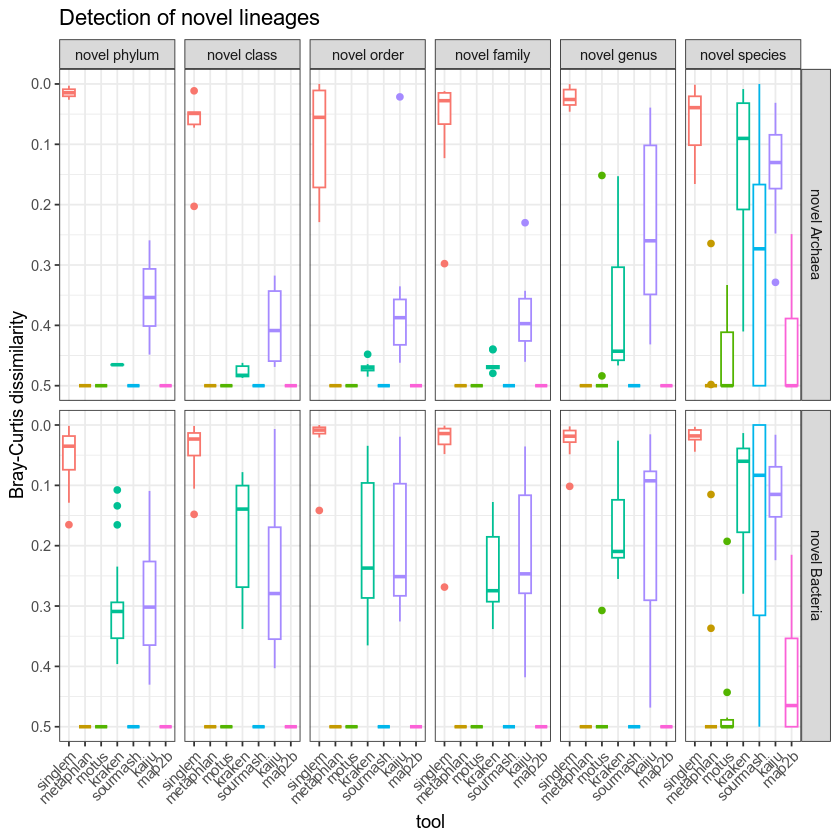

In [7]:
qplot(data=novelty_benchmark_results[rank=='kingdom'], tool, value, geom='boxplot', main='Detection of novel lineages', colour=tool, ylab='Bray-Curtis dissimilarity')+facet_grid(kingdom~novelty_category_novel)+theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_y_reverse()

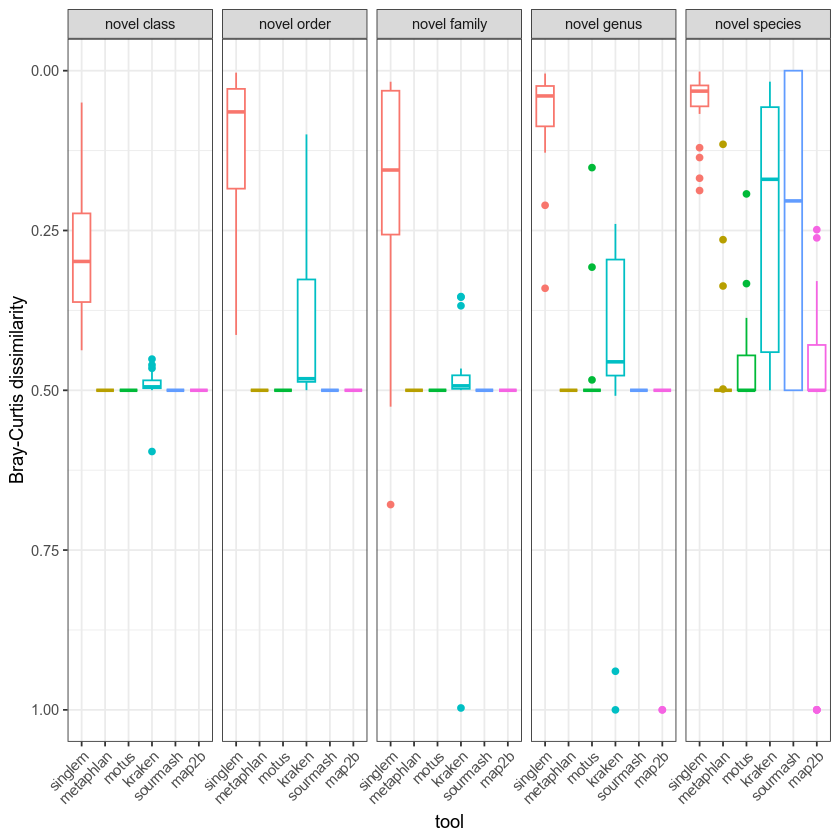

In [8]:
# What about when the rank equals one level above the novelty category?

# novelty_benchmark_results
# novelty_benchmark_results[tool != 'kaiju'][novelty_category != 'phylum'][rank==orders[as.numeric(novelty_category)-1]]
qplot(data=novelty_benchmark_results[tool != 'kaiju'][novelty_category != 'phylum'][rank==orders[as.numeric(novelty_category)-1]], colour=tool, ylab='Bray-Curtis dissimilarity', tool, value, geom='boxplot')+facet_grid(.~novelty_category_novel)+theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_y_reverse()

In [9]:
# Read non-novelty results
marine = fread('1_novel_strains/bray-curtis.csv')

In [10]:
runtimes = fread('1_novel_strains/runtime.csv')

In [11]:
novelty_benchmark_results[, tool2 := name_to_publication_name(tool)]
marine[, tool2 := name_to_publication_name(tool)]
runtimes[, tool2 := name_to_publication_name(tool)]

my_colours = c(
#1b9e77 Dark2
#d95f02
#7570b3
#e7298a
#66a61e
#e6ab02
#a6761d
#666666
'#e7298a',
'#1b9e77',
'#d95f02',
'#7570b3',
'#66a61e',
'#e6ab02',
'#a6761d',
'#666666'

#     '#e7298a','#1b9e77', #?
# '#d95f02',
# '#7570b3',

# '#66a61e',
# '#e6ab02'
)
options(repr.plot.width=7, repr.plot.height=10)

# library(ggbreak)
runtimes2 = runtimes[threads==1, .(mins=mean(s/60), max_rss=mean(max_rss/1000), hours_sd=sd(s/60/60), max_rss_sd=sd(max_rss/1000)), by=.(tool2)]

In [12]:
# ggbreak doesn't get applied so can't use ggarrange


# rp = qplot(data=runtimes2, xlab='', tool2, mins, geom='col', fill=tool2, ylab='Runtime (mins)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_fill_manual(breaks=tools2_order, values=my_colours)+scale_y_break(c(750,6200))

# library(patchwork)

# ggarrange(
#     qplot(data=novelty_benchmark_results[rank=='kingdom'], xlab='', tool2, value, geom='boxplot', colour=tool2, ylab='Bray-Curtis dissimilarity')+facet_grid(kingdom~novelty_category_novel)+theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none') +scale_color_manual(breaks=tools2_order, values=my_colours)+scale_y_reverse(),

#     qplot(data=novelty_benchmark_results[tool != 'kaiju'][rank==orders[as.numeric(novelty_category)-1]], colour=tool2, ylab='Dissimilarity', tool2, value, xlab='', geom='boxplot')+facet_grid(.~novelty_category_novel)+theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_y_reverse() +scale_color_manual(breaks=tools2_order, values=my_colours),

#     ggarrange(
#         qplot(data=marine[rank=='species'], xlab='', ylim=c(0.6,0), tool2, value, geom='boxplot', colour=tool2, ylab='Dissimilarity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_color_manual(breaks=tools2_order, values=my_colours),

#         rp,

#         qplot(data=runtimes[threads==1], xlab='', tool2, max_rss/1000, geom='boxplot', colour=tool2, ylab='Memory (GB)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_color_manual(breaks=tools2_order, values=my_colours),

#         labels=c('C','D','E'),
#         nrow=1
#     ),

#     nrow=3,
#     labels=c('A','B'),
#     heights=c(2,1.2,1.2)
# )

In [13]:
runtimes[, mean(s/60), by=tool2]

tool2,V1
<fct>,<dbl>
SingleM,76.25884
MetaPhlAn,379.24973
mOTUs,403.07242
Kraken2,35.48853
sourmash,96.78899
Kaiju,659.40006
MAP2B,60.97052


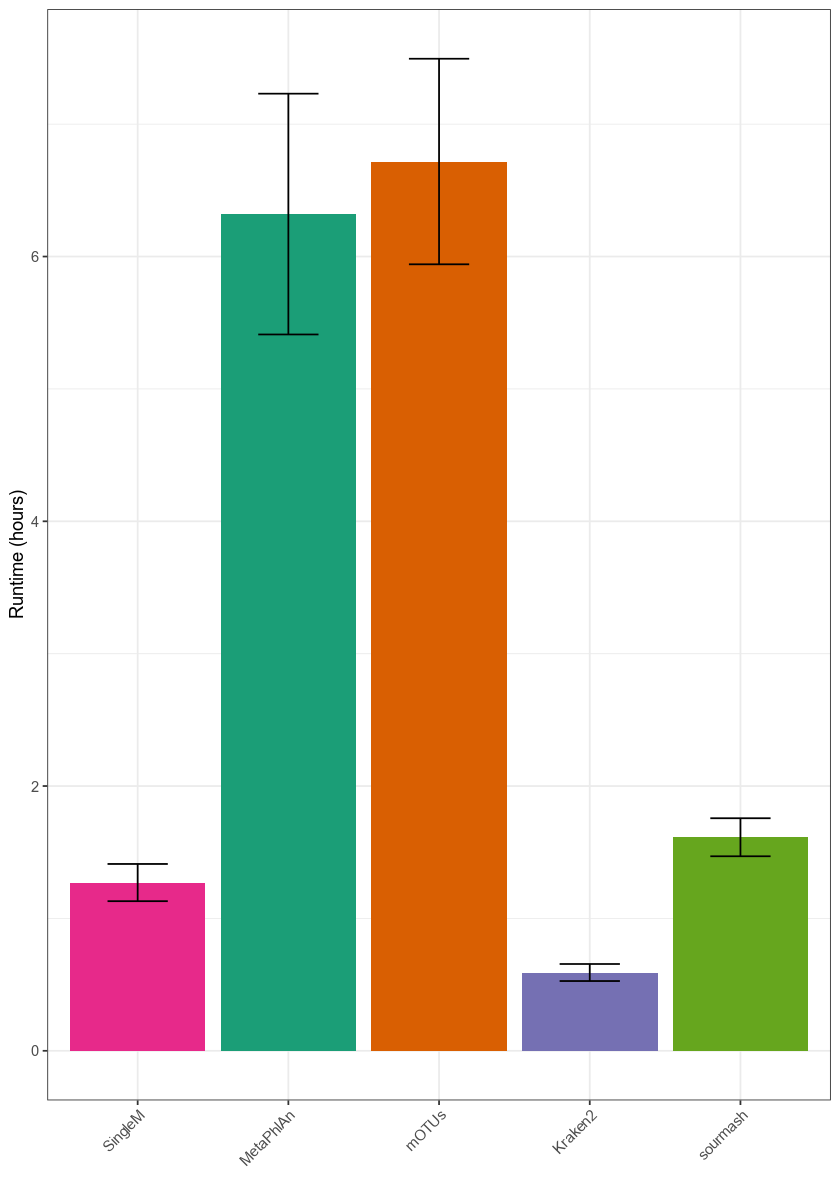

In [14]:
qplot(data=runtimes2[tool2 %in% correct_taxonomy_tools_publication_names], xlab='', tool2, mins/60, geom='col', fill=tool2, ylab='Runtime (hours)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_fill_manual(breaks=tools2_order, values=my_colours)+geom_errorbar(aes(ymin=mins/60-hours_sd, ymax=mins/60+hours_sd), width=.4)

Warning message:
“package ‘ggbeeswarm’ was built under R version 4.2.2”


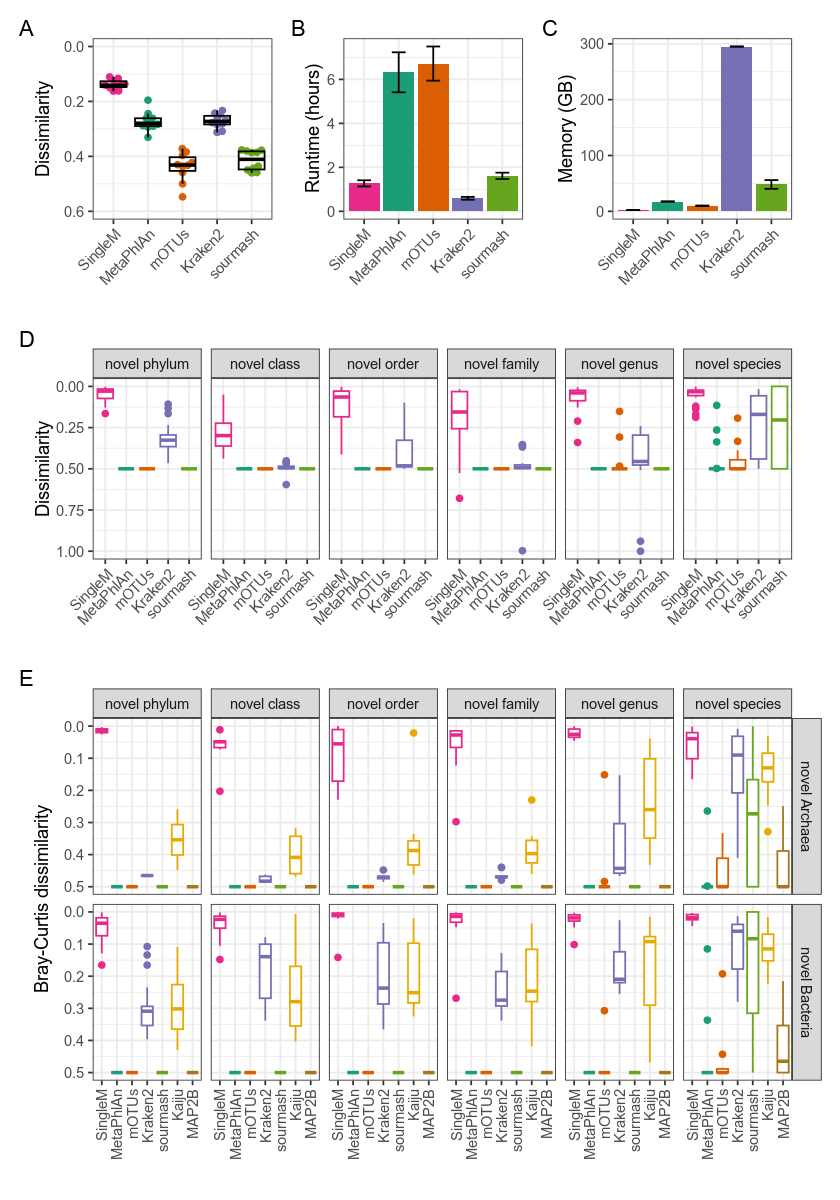

In [15]:
library(patchwork)
library(ggbeeswarm)
options(repr.plot.width=7, repr.plot.height=10)

plot1 = qplot(data=novelty_benchmark_results[rank=='kingdom'], xlab='', tool2, value, geom='boxplot', colour=tool2, ylab='Bray-Curtis dissimilarity')+facet_grid(kingdom~novelty_category_novel)+theme(legend.position='none') +scale_color_manual(breaks=tools2_order, values=my_colours)+scale_y_reverse() +theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))

plot2 = qplot(data=novelty_benchmark_results[tool %in% correct_taxonomy_tools][rank==orders[as.numeric(novelty_category)-1]], colour=tool2, ylab='Dissimilarity', tool2, value, xlab='', geom='boxplot')+facet_grid(.~novelty_category_novel)+theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_y_reverse() +scale_color_manual(breaks=tools2_order, values=my_colours)

# plot31 = qplot(data=marine[rank=='species'], xlab='', ylim=c(0.6,0), tool2, value, geom='boxplot', colour=tool2, ylab='Dissimilarity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_color_manual(breaks=tools2_order, values=my_colours)+geom_beeswarm(cex=3)
plot31 = ggplot(data=marine[rank=='species'], aes(x=tool2, y=value, colour=tool2))+ ylab('Dissimilarity')+xlab('')+ylim(c(0.6,0)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_color_manual(breaks=tools2_order, values=my_colours)+geom_beeswarm(cex=3)+geom_boxplot(outlier.shape=NA, alpha=0, colour='black')

plot32 = qplot(data=runtimes2[tool2 %in% correct_taxonomy_tools_publication_names], xlab='', tool2, mins/60, geom='col', fill=tool2, ylab='Runtime (hours)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_fill_manual(breaks=tools2_order, values=my_colours)+geom_errorbar(aes(ymin=mins/60-hours_sd, ymax=mins/60+hours_sd), width=.4)

plot33 = qplot(data=runtimes2[tool2 %in% correct_taxonomy_tools_publication_names], xlab='', tool2, max_rss, geom='col', fill=tool2, ylab='Memory (GB)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_fill_manual(breaks=tools2_order, values=my_colours)+geom_errorbar(aes(ymin=max_rss-max_rss_sd, ymax=max_rss+max_rss_sd), width=.4)

(plot31 + plot32 + plot33) / plot2 / plot1 + 
  plot_annotation(tag_levels = list(c('A','B','C','D','E')))+
  plot_layout(heights = c(1,1,2))# & theme(plot.tag=element_text(vjust=-1.5))

# ggsave('fig2.svg', width=7, height=10)
# ggsave('fig2.png', width=7, height=10)

# previously, scale break messes up patchwork, so make 2 plots and combine in inkscape later - no longer need ggbreak so comment bad
# plot_spacer() / (plot_spacer() + plot32 + plot_spacer()) / plot_spacer() + 
# #   plot_annotation(tag_levels = list(c('D')))+
#   plot_layout(heights = c(1.2,1.2,2)) & theme(plot.tag=element_text(vjust=-1.5))
# ggsave('fig2_second_half.svg', width=7, height=10)


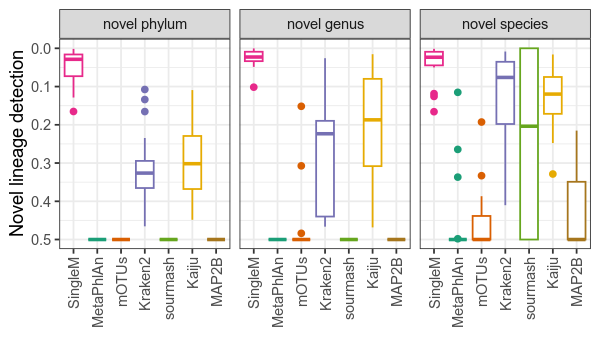

In [16]:
options(repr.plot.width=5, repr.plot.height=3)
qplot(data=novelty_benchmark_results[rank=='kingdom' & novelty_category_novel %in% c('novel phylum','novel genus','novel species')], xlab='', tool2, value, geom='boxplot', colour=tool2, ylab='Novel lineage detection')+facet_grid(.~novelty_category_novel)+theme(legend.position='none') +scale_color_manual(breaks=tools2_order, values=my_colours)+scale_y_reverse() +theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))
# ggsave('novel_lineage_detection.svg', width=5, height=3)

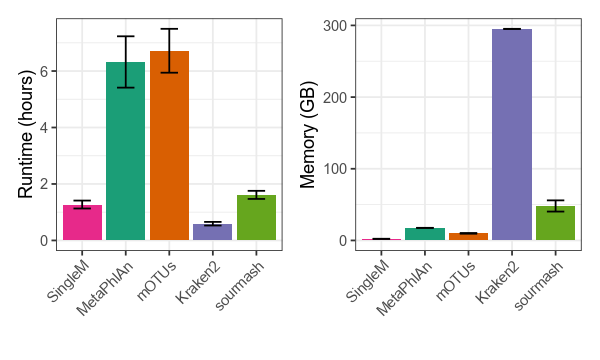

In [17]:
plot32 + plot33

In [23]:
# Write table of runtime stats as a CSV so we can make a supplementary table to show the data behind the runtime plots
write.table('1_novel_strains/runtimes_readable.csv', x=runtimes[,.(community, tool=tool2, runtime_seconds=s, max_rss)], sep=',', quote=FALSE, row.names=FALSE, col.names=TRUE)